In [1]:
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pypylon import pylon
from basler_camera import BaslerCamera, list_basler_cameras
import subprocess as sp
import os
import traceback

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

# dont use gpu
# tf.config.set_visible_devices([], 'GPU')

# Set GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:")
for gpu in gpus:
    print(gpu)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print("Setting memory growth for GPU:", gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# list available cameras
print("Cameras Available:")
cameras = list_basler_cameras()


# Acquisition Parameters
EXPOSURE_TIME, GAIN, CAMERA_FORMAT, WIDTH, HEIGHT, OFFSETX, OFFSETY = 7000.0, 0.0, "Mono8", 2048, 2048, 340, 0

2024-09-17 17:51:46.985620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


GPUs Available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Setting memory growth for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2024-09-17 17:51:47.002008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-17 17:51:47.002115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-17 17:51:47.003438: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 17:51:47.004561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

1 Physical GPUs, 1 Logical GPUs
Cameras Available:
a2A2448-105g5m_40490701


In [2]:
# get a single image from the camera
with BaslerCamera(
    index=0,
    FPS=100,
    EXPOSURE_TIME=EXPOSURE_TIME,
    GAIN=GAIN,
    WIDTH=WIDTH,
    HEIGHT=HEIGHT,
    OFFSETX=OFFSETX,
    OFFSETY=OFFSETY,
    TRIGGER_MODE="Continuous",
    CAMERA_FORMAT=CAMERA_FORMAT,
    record_video=False,
    video_output_path=None,
    video_output_name=None,
    lossless=True,
    debug=False,
) as camera:
    camera.start()
    image = camera.get_array()
    camera.stop()

Trigger mode set to Continuous. FPS will be ignored.
Getting camera...
a2A2448-105g5m_40490701
Found 1 cameras.
Camera a2A2448-105g5m_40490701 selected.
Registered continuous acquisition configuration.
MaxNumBuffer set to 763200. Acquisitions will be limited to 2 hours. To change, modify the code.
Camera initialized.
Exposure time set to 7000.0 microseconds.
Gain set to 0.0 dB.
Set width to 2048, height to 2048, offset to (340, 0).
Camera initialized.


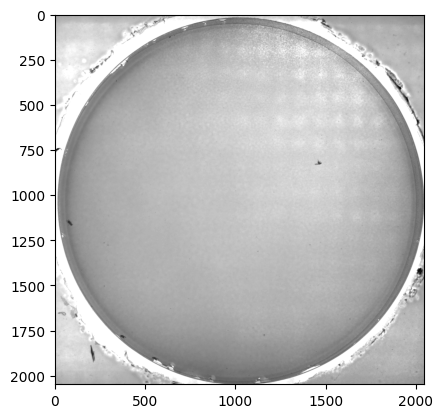

In [3]:
plt.imshow(image, cmap="gray")

In [4]:
QUADRANT = False

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 2048, 2048, 32)    320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1024, 1024, 32)   0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 1024, 1024, 64)    18496     
                                                                 
 conv2d_17 (Conv2D)          (None, 1024, 1024, 64)    36928     
                                                                 
 up_sampling2d_3 (UpSampling  (None, 2048, 2048, 64)   0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 2048, 2048, 32)   

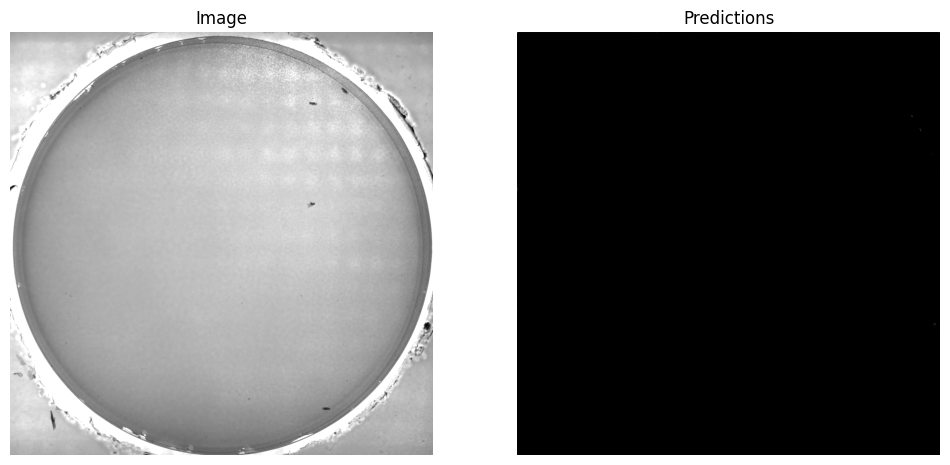

In [11]:
# create a random convolutional neural network for testing

# create a unet model
model = tf.keras.models.Sequential(
    [
        # Encoder
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(WIDTH//2, HEIGHT//2, 1) if QUADRANT else (WIDTH, HEIGHT, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        
        # Decoder
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ]
)


# compile the model
model.compile(
    optimizer='adam', # optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function
    metrics=['accuracy'] # metrics
)

# print model summary
model.summary()

# break image into 4 quadrants to create a batch of 4 images
image_ = image.reshape(1, WIDTH, HEIGHT, 1)
if QUADRANT:
    image_ = np.concatenate([image_[:, :WIDTH//2, :HEIGHT//2], image_[:, WIDTH//2:, :HEIGHT//2], image_[:, :WIDTH//2, HEIGHT//2:], image_[:, WIDTH//2:, HEIGHT//2:]], axis=0)
print(image_.shape)

predictions = model.predict(image_).squeeze()

# plot the image and the predictions
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Image")
ax[0].axis('off')
# reconstruct the image
if QUADRANT:
    predictions = np.concatenate([
        np.concatenate([predictions[0], predictions[2]], axis=1),
        np.concatenate([predictions[1], predictions[3]], axis=1)
    ], axis=0)
ax[1].imshow(predictions, cmap='gray')
ax[1].set_title("Predictions")
ax[1].axis('off')
plt.show()

In [14]:
# create an acquisition + prediction loop

BATCH_SIZE = 4
DRAW = True
MAX_FRAMES = 1000

update_period = 1 # seconds

previous_time = time.perf_counter()
last_display = time.perf_counter() - 1.1*update_period

fps = np.zeros(MAX_FRAMES)

# setup live frame rate and gpu memory plot
if DRAW:
    %matplotlib qt
    fig, ax = plt.subplots(1, 1, figsize=(12,3))
    ax.set_title("Resource Usage")
    ax.set_xlabel("Frame")
    ax.set_ylabel("FPS (Hz)", color='k')
    ax.grid()
    line1, = ax.plot([], [], 'k-')
    plt.tight_layout()
    plt.ion()
    plt.show()



# WARM UP THE GPU
start_time = time.perf_counter()
while time.perf_counter() - start_time < 10:
    image = np.random.rand(1, WIDTH//2, HEIGHT//2, 1) if QUADRANT else np.random.rand(1, WIDTH, HEIGHT, 1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.repeat(image, BATCH_SIZE, axis=0)
    predictions = model.predict(image, verbose=0)

# dont use the gpu for this
with BaslerCamera(
    index=0,
    FPS=100,
    EXPOSURE_TIME=EXPOSURE_TIME,
    GAIN=GAIN,
    WIDTH=WIDTH,
    HEIGHT=HEIGHT,
    OFFSETX=OFFSETX,
    OFFSETY=OFFSETY,
    TRIGGER_MODE="Continuous",
    CAMERA_FORMAT=CAMERA_FORMAT,
    record_video=False,
    video_output_path=None,
    video_output_name=None,
    lossless=True,
    debug=False,
) as camera:
    camera.start()
    try:
        frame_count = 0
        while True:
            image = camera.get_array()
            # split the image into 4 quadrants
            image = image.reshape(1, WIDTH, HEIGHT, 1)
            if QUADRANT:
                image = np.concatenate([image[:, :WIDTH//2, :HEIGHT//2], image[:, WIDTH//2:, :HEIGHT//2], image[:, :WIDTH//2, HEIGHT//2:], image[:, WIDTH//2:, HEIGHT//2:]], axis=0)
            # put the image on the gpu
            image = tf.convert_to_tensor(image, dtype=tf.float32)
            # repeat the image to match the batch size
            # pass the image through the model
            if BATCH_SIZE > 1:
                image = tf.repeat(image, BATCH_SIZE, axis=0)
            predictions = model.predict(image, verbose=0)
            # track frame rate
            current_time = time.perf_counter()
            frame_rate = 1 / (current_time - previous_time)
            previous_time = current_time
            fps[frame_count] = frame_rate
            frame_count += 1
            if current_time - last_display > update_period and DRAW:
                last_display = current_time
                # update the plot
                line1.set_xdata(np.arange(frame_count))
                line1.set_ydata(fps[:frame_count])
                ax.relim()
                ax.autoscale_view()
                fig.canvas.draw()
                fig.canvas.flush_events()
            if frame_count >= MAX_FRAMES:
                break
    except KeyboardInterrupt:
        pass
    except Exception as e:
        # get stack trace and save to file
        with open("error.txt", "w") as f:
            f.write(str(e))
            f.write("\n")
            f.write(str(sys.exc_info()))
            f.write("\n")
            f.write(traceback.format_exc())
    # save the data
    np.save("fps.npy", fps)
    camera.stop()

Trigger mode set to Continuous. FPS will be ignored.
Getting camera...
a2A2448-105g5m_40490701
Found 1 cameras.
Camera a2A2448-105g5m_40490701 selected.
Registered continuous acquisition configuration.
MaxNumBuffer set to 763200. Acquisitions will be limited to 2 hours. To change, modify the code.
Camera initialized.
Exposure time set to 7000.0 microseconds.
Gain set to 0.0 dB.
Set width to 2048, height to 2048, offset to (340, 0).
Camera initialized.


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7df7c8bd1280>
Traceback (most recent call last):
  File "/home/rutalab/mambaforge/envs/flyprojection/lib/python3.9/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 571, in __del__
    gen_dataset_ops.delete_iterator(
  File "/home/rutalab/mambaforge/envs/flyprojection/lib/python3.9/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1402, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
TypeError: stop() takes 1 positional argument but 3 were given


In [7]:
plt.plot(fps)